In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams["font.size"] = 11

file_path = '../results/decoder_layer.csv'

x_dict = {'4096_14336_8': 'Mixtral-8x7B', 
        '2304_5760_8': 'MiniCPM-MoE', 
        '4096_11008_8': 'MiniCPM',
        '6144_16384_8': 'Mixtral-8x22B', 
        '2048_8192_32': 'OpenMoE-8B',
        '3072_12288_32': 'OpenMoE-34B',
        '2048_1408_64': 'DeepSeek-MoE',
        '2048_1408_60': 'Qwen2-MoE'
        }

order = ['MiniCPM-MoE', 'OpenMoE-34B', 'Mixtral-8x7B', 'Mixtral-8x22B', 'Qwen2-MoE', 'DeepSeek-MoE']

df = pd.read_csv(file_path)

In [3]:
def select_data(df, batch_size_list, para_lists=[(4096,14336,8), (2304,5760,8), (6144,16384,8), (2048,8192,32), (3072,12288,32), (2048,1408,64), (2048,1408,60)], mode='eager'):
    data = {}

    for index, row in df.iterrows():
        batch_size = row['batch_size']
        hidden_size = row['hidden_size']
        intermediate_size = row['intermediate_size']
        kernel_type = row['kernel type']
        time = row['time']
        name = row['model']
        expert_num = row['expert_num']
        
        if batch_size not in batch_size_list:
            continue
        if mode != row['atten_mode']:
            continue
        if (hidden_size, intermediate_size, expert_num) not in para_lists:
            continue

        name = f"{hidden_size}_{intermediate_size}_{expert_num}"
        if name not in data:
            data[name] = {'GEMM': 0, 'megablocks': 0, 'vLLM': 0, 'Samoyeds': 0}

        if kernel_type == 'GEMM':
            data[name]['GEMM'] = time
        elif kernel_type == 'vLLM':
            data[name]['vLLM'] = time
        elif kernel_type == 'Samoyeds':
            data[name]['Samoyeds'] = time
        elif kernel_type == 'megablocks':
            data[name]['megablocks'] = time

    data_array = [[x_dict[name]] + list(values.values()) for name, values in data.items()]
    
    return data_array

               GEMM  megablocks      vLLM  Samoyeds
name                                               
MiniCPM-MoE     1.0    1.041657  1.040051  1.287415
OpenMoE-34B     1.0         inf       inf  2.361097
Mixtral-8x7B    1.0    1.106624  1.110466  1.444471
Mixtral-8x22B   1.0         inf       inf  1.010705
Qwen2-MoE       1.0    1.042386  1.085160  1.113643
DeepSeek-MoE    1.0    1.079136  1.178553  1.303554


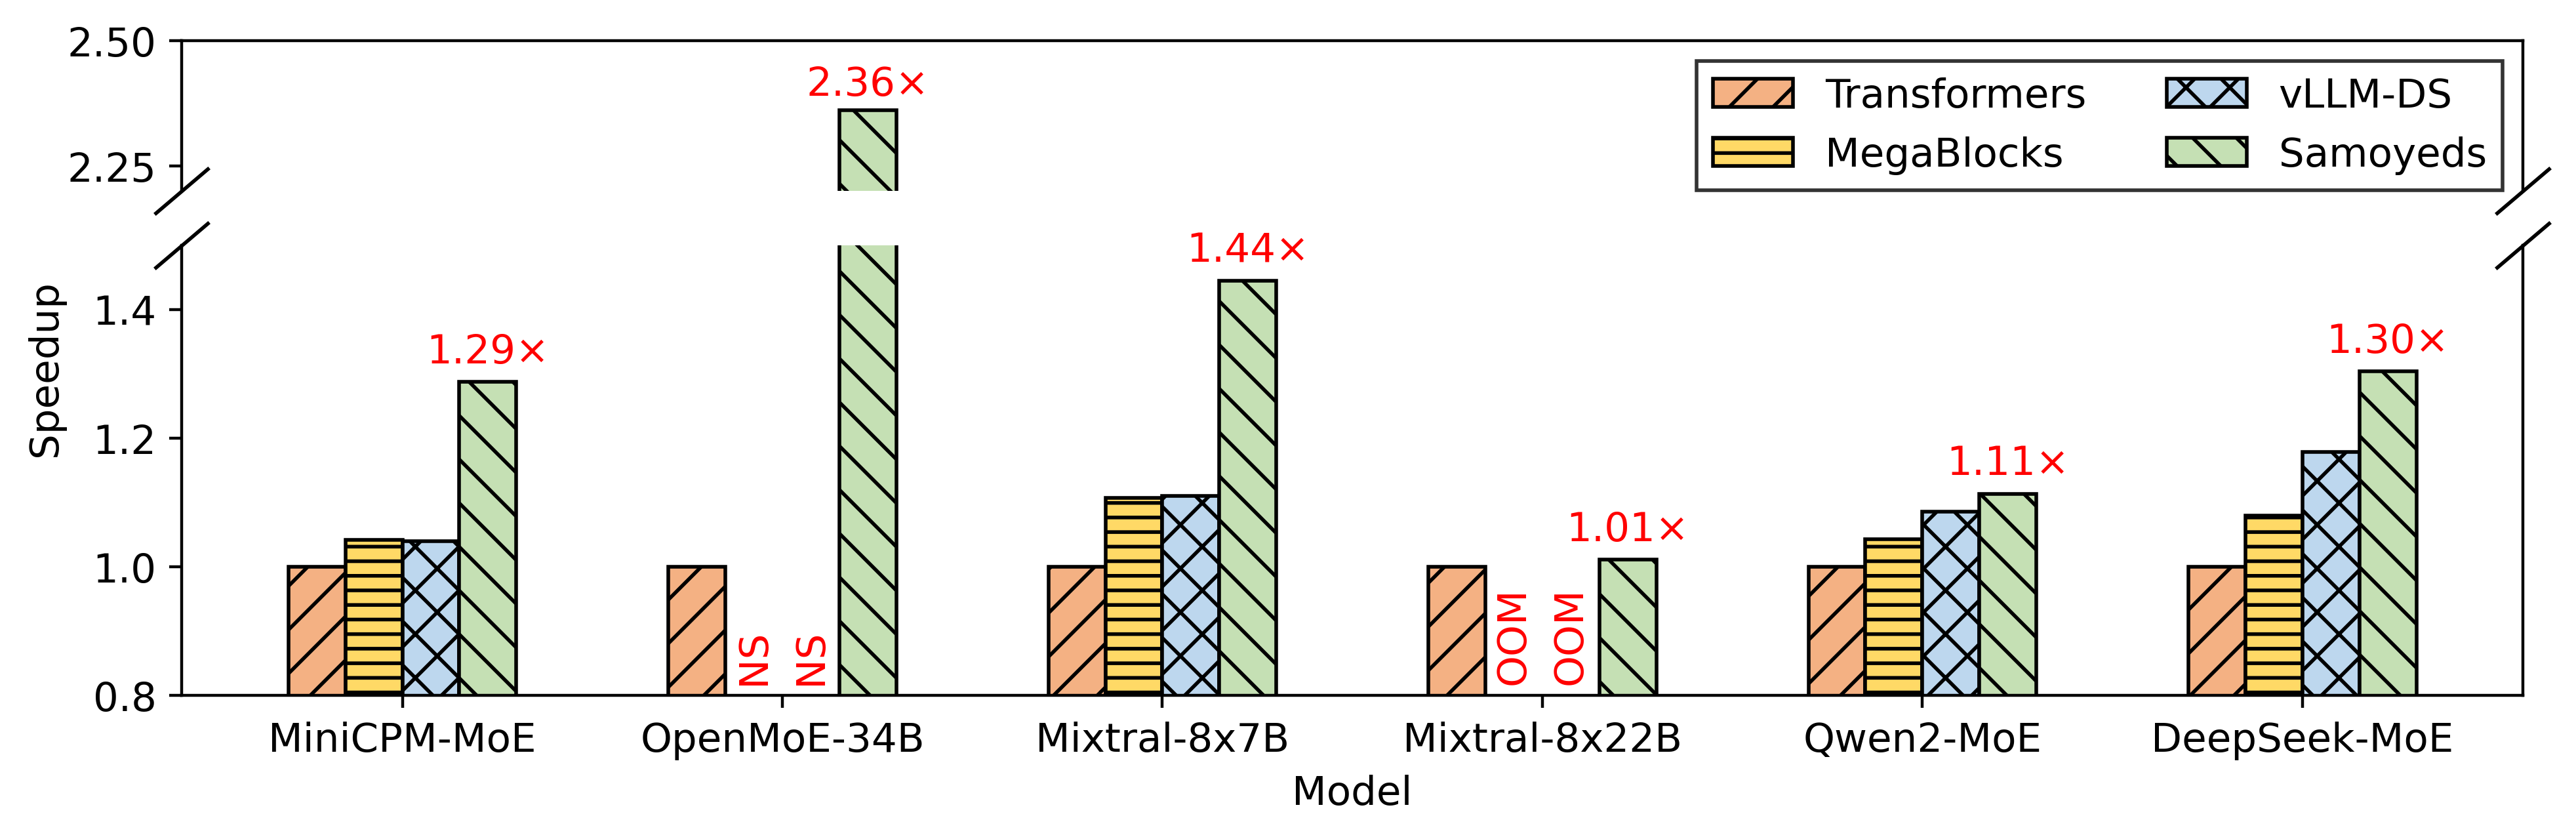

In [4]:
flash_attention_data_array = select_data(df, batch_size_list=[1,16,14], para_lists=[(4096,14336,8), (2304,5760,8), (6144,16384,8), (2048,8192,32), (3072,12288,32), (2048,1408,64), (2048,1408,60)], mode='flash_attention_2')

flash_attention_data_df = pd.DataFrame(flash_attention_data_array, columns=['name', 'GEMM', 'megablocks', 'vLLM', 'Samoyeds'])
flash_attention_data_df.set_index('name', inplace=True)
data_df = flash_attention_data_df.loc[order]

data_df['megablocks'] = data_df['GEMM'] / data_df['megablocks']
data_df['vLLM'] = data_df['GEMM'] / data_df['vLLM']
data_df['Samoyeds'] = data_df['GEMM'] / data_df['Samoyeds']
data_df['GEMM'] = data_df['GEMM'] / data_df['GEMM']

print(data_df)

data_df.rename(columns={'GEMM': 'Transformers', 'megablocks': 'MegaBlocks', 'vLLM': 'vLLM-DS', 'Samoyeds': 'Samoyeds'}, inplace=True)

import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[1,3])

fig = plt.figure(figsize=(10, 3), dpi=400)

ax2 = plt.subplot(gs[1])
ax1 = plt.subplot(gs[0])

ax1.set_ylim(2.2, 2.5) 
ax2.set_ylim(0.8, 1.5) 

ax1.tick_params(axis='x', which='both', bottom=False)

import numpy as np
x = np.arange(len(data_df.index))
width = 0.15
colors = ['#F4B183', '#FFD966', '#BDD7EE', '#C5E0B4']
hatches = ['//', '---', 'xx', '\\\\']

for i, (column, color, hatch) in enumerate(zip(data_df.columns, colors, hatches)):
    ax1.bar(x - width/2 - width + i*width, data_df[column].values, width=width, color=color, edgecolor='black', hatch=hatch, label=column)
    ax2.bar(x - width/2 - width + i*width, data_df[column].values, width=width, color=color, edgecolor='black', hatch=hatch, label=column)

for i, bar in enumerate(ax1.patches):
    if i == 19:
        ax1.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.03, f'{bar.get_height():.2f}\u00D7', ha='center', color='red')

for i, bar in enumerate(ax2.patches):
    if i/data_df.shape[0] >= 3:
        if i != 19:
            ax2.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.03, f'{bar.get_height():.2f}\u00D7', ha='center', color='red')

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xticks(x)
ax2.set_xticklabels(data_df.index, rotation=0)
ax1.set_xticklabels([])

legend = ax1.legend(loc='upper right', ncol=2, frameon=True, fancybox=False)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('none')

# OpenMoE no supported
ax2.text((ax2.patches[7].get_x() + ax2.patches[13].get_x())/2, 0.83, 'NS', ha='center', rotation=90, color='red')
ax2.text((ax2.patches[13].get_x() + ax2.patches[19].get_x())/2, 0.83, 'NS', ha='center', rotation=90, color='red')
# OOM
ax2.text((ax2.patches[9].get_x() + ax2.patches[15].get_x())/2, 0.83, 'OOM', ha='center', rotation=90, color='red')
ax2.text((ax2.patches[15].get_x() + ax2.patches[21].get_x())/2, 0.83, 'OOM', ha='center', rotation=90, color='red')

d = .85
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=15,
              linestyle='none', color='black', mec='black', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0],transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.set_xlabel("Model")
ax = fig.add_subplot(111, frame_on=False)
ax.set_ylabel("Speedup")
ax.yaxis.set_label_coords(-0.05, 0.5)

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.tight_layout(pad=0)

plt.show()